In [ ]:
!pip install qiskit
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

Bell pair counts: {'11': 1046, '00': 1002}


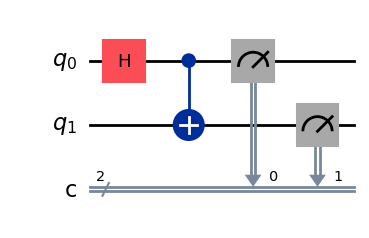

In [3]:

# Qiskit ≥ 1.0
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Bell state on 2 qubits, measure both
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

backend = AerSimulator()
tqc = transpile(qc, backend)          # <-- replaces execute()
job = backend.run(tqc, shots=2048)    # <-- run the transpiled circuit
result = job.result()
counts = result.get_counts()
print("Bell pair counts:", counts)  # ~{'00': ~1024, '11': ~1024}, up to sampling noise

qc.draw('mpl')


In [6]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

def bell_state(i):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    # modify based on index 0–3
    if i == 1: qc.z(0)       # Φ−
    elif i == 2: qc.x(1)     # Ψ+
    elif i == 3: qc.z(0); qc.x(1)  # Ψ−
    return Statevector.from_instruction(qc)

labels = ["Φ⁺", "Φ⁻", "Ψ⁺", "Ψ⁻"]
for i in range(4):
    psi = bell_state(i)
    print(f"|{labels[i]}> =", psi.data.round(3))


|Φ⁺> = [0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]
|Φ⁻> = [ 0.707+0.j  0.   +0.j  0.   +0.j -0.707+0.j]
|Ψ⁺> = [0.   +0.j 0.707+0.j 0.707+0.j 0.   +0.j]
|Ψ⁻> = [ 0.   +0.j -0.707+0.j  0.707+0.j  0.   +0.j]


In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity

def arbitrary_single_qubit(theta, phi):
    """Prepare |ψ> = cos(theta/2)|0> + e^{i phi} sin(theta/2)|1> on qubit 0 (in a 3q circuit)."""
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi,   0)
    return qc

def teleportation_unitary():
    """Teleport from qubit 0 to qubit 2 using unitary (deferred) corrections."""
    qc = QuantumCircuit(3)
    # Create Bell pair between qubits 1 and 2
    qc.h(1)
    qc.cx(1, 2)
    # Bell-basis operation on qubits 0 and 1
    qc.cx(0, 1)
    qc.h(0)
    # Deferred-measurement corrections: X^(m1)Z^(m0) → CX(1→2) then CZ(0→2)
    qc.cx(1, 2)
    qc.cz(0, 2)
    return qc

# --- Build full circuit: prepare |ψ> then teleport it to qubit 2
theta, phi = 1.1, 0.7
prep = arbitrary_single_qubit(theta, phi)
tele = teleportation_unitary()
full = prep.compose(tele)

# Final 3-qubit state after teleportation
psi_out = Statevector.from_instruction(full)

# Reduced state (destination qubit 2)
rho_2 = partial_trace(psi_out, [0, 1])            # DensityMatrix for qubit 2

# Ideal single-qubit |ψ> to compare against
qc_ideal = QuantumCircuit(1)
qc_ideal.ry(theta, 0)
qc_ideal.rz(phi,   0)
psi_ideal_1q = Statevector.from_label('0').evolve(qc_ideal)

# Fidelity between teleported output and the target |ψ>
F = state_fidelity(DensityMatrix(rho_2), psi_ideal_1q)
print(f"Teleportation fidelity ≈ {F:.6f}")  # ≈ 1.000000 in noiseless simulation
